In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import os
import hydra
from hydra import initialize_config_module, initialize, compose
from hydra.core.global_hydra import GlobalHydra
import sys
import cv2
from scipy.stats import mode
import supervision as sv
from supervision.draw.color import Color, ColorPalette
from shapely.geometry import Polygon
from PIL import Image
import gc

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Collect garbage
gc.collect()

# Free up GPU memory
torch.cuda.empty_cache()


# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.float16).__enter__()
 
if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [2]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
 
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0,0,1,0.4), thickness=1) 
 
    ax.imshow(img)

In [3]:
# Load the image
image_bgr = cv2.imread('ScanAI/datasets/aalesund/1504200/200.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [4]:
import os
import torch
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# Move the model to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mask_generator = SAM2AutomaticMaskGenerator.from_pretrained(
    model_id="facebook/sam2-hiera-large",
    points_per_side=16,  # Define points per side
    points_per_batch=8,  # Number of points per batch
    pred_iou_thresh=0.0,  # Filter threshold for mask quality
    stability_score_thresh=0.95,  # Filter threshold for stability score
    stability_score_offset=1.0,
    mask_threshold=0.0,
    box_nms_thresh=1,           
    crop_n_layers=0,
    crop_nms_thresh=1,
    crop_overlap_ratio=0.2,        
    crop_n_points_downscale_factor=1,
    point_grids=None,
    min_mask_region_area=0,
    output_mode="binary_mask",
    use_m2m=True,                  
    multimask_output=False
)


"""# Paths to configuration and checkpoint files
config_file_path = "ScanAI/sam2.1_hiera_l.yaml"  # Config file in root directory
checkpoint_file_path = "ScanAI/sam2.1_hiera_large.pt"  # Checkpoint file in root directory

# Verify file existence
assert os.path.exists(config_file_path), f"Config file not found at {config_file_path}"
assert os.path.exists(checkpoint_file_path), f"Checkpoint file not found at {checkpoint_file_path}"

# Clear any existing Hydra instances
GlobalHydra.instance().clear()

# Initialize Hydra
with initialize(config_path="."):
    # Now you can call build_sam2
    print("Attempting to initialize the SAM2 model...")
    sam2_model = build_sam2(config_file=config_file_path, ckpt_path=checkpoint_file_path).to(device)

sam2_model.to(device)

# Create mask generator
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=84,
    points_per_batch=16,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.9,
    stability_score_offset=1.0,
    mask_threshold=0.0,
    box_nms_thresh=1,           
    crop_n_layers=1,
    crop_nms_thresh=0.7,
    crop_overlap_ratio=0.2,        
    crop_n_points_downscale_factor=1,
    point_grids=None,
    min_mask_region_area=100,
    output_mode="binary_mask",
    use_m2m=True,                  
    multimask_output=False
)"""


print("Model and mask generator initialized successfully.")


/home/siverteh/miniconda/lib/python3.12/site-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


Model and mask generator initialized successfully.


In [5]:
sam_result = mask_generator.generate(image_rgb)
print(len(sam_result))

174


In [6]:
# Import necessary modules
import numpy as np

# Define function to check if one mask is completely inside another
def is_mask_inside(outer_mask, inner_mask):
    # Check if all True pixels in inner_mask are also True in outer_mask
    return np.all(outer_mask[inner_mask > 0])

# Step 1: Extract masks, compute area, and compute bounding boxes for sorting
# Include the index to reference back to `sam_result`
masks_with_areas_and_bboxes = []
for i, mask in enumerate(sam_result):
    segmentation = mask['segmentation']
    if np.any(segmentation):
        area = np.sum(segmentation)
        # Compute bounding box
        coords = np.argwhere(segmentation)
        y_coords, x_coords = coords[:, 0], coords[:, 1]
        min_x, max_x = x_coords.min(), x_coords.max()
        min_y, max_y = y_coords.min(), y_coords.max()
        bbox = (min_x, min_y, max_x, max_y)
        masks_with_areas_and_bboxes.append((i, segmentation, area, bbox))

# Sort masks by area (from largest to smallest)
masks_with_areas_and_bboxes.sort(key=lambda x: x[2], reverse=True)  # (index, mask, area, bbox)

# Set the threshold for the minimum number of contained masks required to remove a mask
contained_mask_threshold = int(0.5 * len(masks_with_areas_and_bboxes))

# Identify masks to remove
indices_to_remove = set()

# Loop through masks and remove larger masks that contain multiple smaller masks
for i, (outer_idx, outer_mask, outer_area, outer_bbox) in enumerate(masks_with_areas_and_bboxes):
    outer_min_x, outer_min_y, outer_max_x, outer_max_y = outer_bbox
    contained_count = 0  # Counter for masks contained within the current outer mask

    # Only consider smaller masks
    for inner_idx, inner_mask, inner_area, inner_bbox in masks_with_areas_and_bboxes[i+1:]:
        inner_min_x, inner_min_y, inner_max_x, inner_max_y = inner_bbox

        # Check if inner bounding box is entirely within outer bounding box
        if (inner_min_x >= outer_min_x and inner_max_x <= outer_max_x and
            inner_min_y >= outer_min_y and inner_max_y <= outer_max_y):
            # Now check if inner_mask is inside outer_mask
            if is_mask_inside(outer_mask, inner_mask):
                contained_count += 1  # Increment count for each contained mask

    # Only mark the larger mask for removal if it contains at least `contained_mask_threshold` smaller masks
    if contained_count >= contained_mask_threshold:
        indices_to_remove.add(outer_idx)

# Filter out the unwanted masks
filtered_masks_with_areas_and_bboxes = [
    (idx, mask, area, bbox)
    for idx, mask, area, bbox in masks_with_areas_and_bboxes
    if idx not in indices_to_remove
]

# Also remove any masks that cover the entire image (if any)
image_area = image_bgr.shape[0] * image_bgr.shape[1]
filtered_masks_with_areas_and_bboxes = [
    (idx, mask, area, bbox)
    for idx, mask, area, bbox in filtered_masks_with_areas_and_bboxes
    if area < image_area
]

# Create a filtered sam_result
filtered_sam_result = [sam_result[idx] for idx, _, _, _ in filtered_masks_with_areas_and_bboxes]

# Get the sorted masks
sorted_masks = [mask for _, mask, _, _ in filtered_masks_with_areas_and_bboxes]

# Define custom function to find the mode of an array
def custom_mode(array):
    values, counts = np.unique(array, return_counts=True)
    return values[np.argmax(counts)]

# Function to get the most common color within a masked area
def get_most_common_color(image_bgr, mask):
    mask_area = np.where(mask)
    pixels = image_bgr[mask_area]
    if pixels.size == 0 or pixels.ndim != 2 or pixels.shape[1] != 3:
        return (0, 0, 0)

    # Use custom mode for each channel (BGR order)
    b_mode = int(custom_mode(pixels[:, 0]))
    g_mode = int(custom_mode(pixels[:, 1]))
    r_mode = int(custom_mode(pixels[:, 2]))
    return (b_mode, g_mode, r_mode)  # Increase brightness for visibility

# Generate ColorPalette with BGR colors based on sorted mask order
sorted_mask_colors = [
    Color.from_bgr_tuple(get_most_common_color(image_bgr, mask)) for mask in sorted_masks
]
custom_color_palette = ColorPalette(colors=sorted_mask_colors)

# Convert filtered SAM result to detections and annotate using the sorted colors
detections = sv.Detections.from_sam(sam_result=filtered_sam_result)
mask_annotator = sv.MaskAnnotator(color=custom_color_palette, opacity=1)

# Create a custom color lookup array based on sorted colors
custom_color_lookup = np.arange(len(sorted_mask_colors))

try:
    # Annotate the image with the custom color palette in BGR
    annotated_image_with_custom_colors = mask_annotator.annotate(
        scene=image_bgr.copy(),  # Input image in BGR
        detections=detections,
        custom_color_lookup=custom_color_lookup
    )

    # Display the original and annotated images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))  # Convert for display only
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(annotated_image_with_custom_colors, cv2.COLOR_BGR2RGB))  # Convert for display
    plt.title("Annotated Image with Filtered Masks")
    plt.axis("off")

    plt.show()

except AssertionError as ae:
    print(f"Assertion error: {ae}")
except Exception as e:
    print(f"Error during annotation: {e}")


AttributeError: type object 'Color' has no attribute 'from_bgr_tuple'

Total polygons after excluding large masks: 87
Polygon 1 is mostly within another polygon and will be removed.
Polygon 2 is mostly within another polygon and will be removed.
Polygon 3 is mostly within another polygon and will be removed.
Polygon 4 is mostly within another polygon and will be removed.
Polygon 5 is mostly within another polygon and will be removed.
Polygon 6 is mostly within another polygon and will be removed.
Polygon 7 is mostly within another polygon and will be removed.
Polygon 8 is mostly within another polygon and will be removed.
Polygon 9 is mostly within another polygon and will be removed.
Polygon 10 is mostly within another polygon and will be removed.
Polygon 11 is mostly within another polygon and will be removed.
Polygon 12 is mostly within another polygon and will be removed.
Polygon 13 is mostly within another polygon and will be removed.
Polygon 14 is mostly within another polygon and will be removed.
Polygon 15 is mostly within another polygon and will

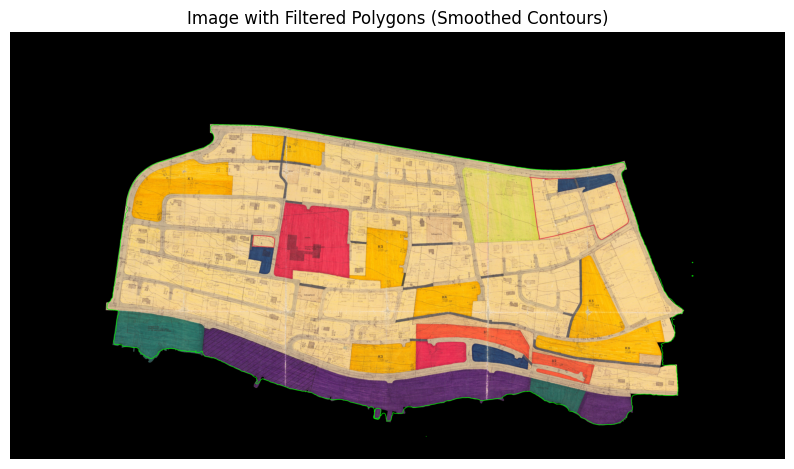

In [7]:
polygons_list = []

# Prepare a copy of the original image for drawing polygons
image_with_polygons = image_bgr.copy()

# Image area
image_area = image_bgr.shape[0] * image_bgr.shape[1]

# List to store polygons with their area
mask_polygons = []

# Function to smooth contour using moving average
def smooth_contour(contour, window_size=5):
    # Ensure window_size is odd
    if window_size % 2 == 0:
        window_size += 1
    half_window = window_size // 2

    # Pad the contour to handle the circular nature
    contour = np.concatenate((contour[-half_window:], contour, contour[:half_window]), axis=0)
    
    smoothed_contour = []
    for i in range(half_window, len(contour) - half_window):
        window_points = contour[i - half_window:i + half_window + 1]
        mean_point = np.mean(window_points, axis=0)
        smoothed_contour.append(mean_point)
    smoothed_contour = np.array(smoothed_contour, dtype=np.int32)
    return smoothed_contour

# Loop over each mask in the filtered SAM result
for idx, mask_dict in enumerate(filtered_sam_result):
    mask = mask_dict['segmentation'].astype(np.uint8)  # Ensure mask is in uint8 format

    # Find contours in the mask
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Skip if no contours are found
    if not contours:
        continue

    # Process each contour
    for contour in contours:
        if contour.shape[0] < 5:
            continue  # Need at least 5 points to smooth

        # Reshape contour to 2D array
        contour = contour.reshape(-1, 2)

        # Smooth the contour using moving average
        smoothed_contour = smooth_contour(contour, window_size=15)  # Adjust window_size as needed

        if smoothed_contour.shape[0] >= 3:
            polygon = Polygon(smoothed_contour)
            # Ensure the polygon is valid
            if not polygon.is_valid or polygon.area == 0:
                # Try fixing invalid polygons
                polygon = polygon.buffer(0)
                if not polygon.is_valid or polygon.area == 0:
                    continue  # Skip if still invalid
            # Store the polygon along with its area and index
            mask_polygons.append({'area': polygon.area, 'polygon': polygon, 'index': idx})

# Introduce max_area_threshold to exclude overly large polygons
max_area_threshold = 0.9 * image_area  # Exclude polygons covering more than 90% of the image

# Filter out masks that are too large
mask_polygons = [mp for mp in mask_polygons if mp['area'] < max_area_threshold]

# Debug: Print the number of polygons after excluding large masks
print(f"Total polygons after excluding large masks: {len(mask_polygons)}")

# Now, filter out smaller polygons that are mostly within larger ones
# Sort polygons by area in descending order
mask_polygons.sort(key=lambda x: x['area'], reverse=True)

# Initialize list to hold the final polygons
filtered_polygons = []

# Function to check if a polygon is mostly within existing polygons
def is_polygon_mostly_within(poly, existing_polys, area_overlap_threshold=0.95):
    for existing_poly in existing_polys:
        intersection_area = poly.intersection(existing_poly).area
        if poly.area == 0:
            continue
        overlap_ratio = intersection_area / poly.area
        if overlap_ratio >= area_overlap_threshold:
            return True
    return False

# Process each polygon
for idx, poly_dict in enumerate(mask_polygons):
    poly = poly_dict['polygon']
    if not is_polygon_mostly_within(poly, [d['polygon'] for d in filtered_polygons], area_overlap_threshold=0.95):
        filtered_polygons.append(poly_dict)
    else:
        print(f"Polygon {idx} is mostly within another polygon and will be removed.")

# Debug: Print the number of polygons after filtering
print(f"Total polygons after overlap filtering: {len(filtered_polygons)}")

# Draw the filtered polygons on the image
for poly_dict in filtered_polygons:
    poly = poly_dict['polygon']
    # Get the exterior coordinates as integer tuples
    coords = np.array(list(poly.exterior.coords)).astype(np.int32)
    # Draw the polygon on the image
    color = (0, 255, 0)  # Green color for polygons (BGR format)
    cv2.polylines(image_with_polygons, [coords], isClosed=True, color=color, thickness=5)
    # Add to the list of polygons for potential export
    polygons_list.append(poly)

# Display the image with vectorized polygons
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_polygons, cv2.COLOR_BGR2RGB))
plt.title("Image with Filtered Polygons (Smoothed Contours)")
plt.axis("off")
plt.show()
